In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from tqdm import tqdm
from time import sleep
import matplotlib.pyplot as plt
import folium
import re

import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

Create some function that are neccessary for later on.

In [2]:
from math import radians, sin, cos, sqrt, atan2
# function that finds he distance between two coordinates
def haversine_distance(coordinates):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = coordinates
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)

    # Haversine formula
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    a = sin(dlat/2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    radius = 6371  # Earth's radius in kilometers
    distance = radius * c

    return distance


from geopy.geocoders import Nominatim
# function that finds the coordinates of an adress
loc = Nominatim(user_agent="GetLoc")

In [43]:
def apartments_details(url):    
    # get access to the site
    response = requests.get(url)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(response.text, "html.parser")
    block = soup.find_all('div',class_="css-ho2tek")


    # scrape boligportal site and get all the info of the apartments there
    details_set,location_set,comments_set,time_posted_set,price_set = [],[],[],[],[]
    for i in block:
        blockII = i.find_all('div')
        if len(blockII) != 1:
            for j in blockII:
                blockIII = j.find_all('div')
                for z in blockIII:
                    blockIV = z.find_all('div',class_="css-1jf5j4m")
                    for v in blockIV:

                        details = v.find_all('div',class_='css-js2eza')
                        location = v.find_all('div',class_='css-1w4wg57')
                        comments = v.find_all('div',class_='css-11zpaaj')
                        price = v.find_all('div',class_='css-btz01o')
                        for l in details:
                            l = l.text.split()
                            num_rooms = l[0]
                            type_ = l[3]
                            size = l[5]
                            try:
                                details_set.append((int(num_rooms),type_,size))
                            except:          
                                # sometimes there are rooms and half (2.5). Pass it as a float instead of int                      
                                num_rooms = num_rooms.replace(',','.')
                                details_set.append((float(num_rooms),type_,size))
                        for l in location:
                            location_set.append(l.text)                                
                        for l in comments:
                            comments_set.append(l.text)                        
                        for l in price:                    
                            # print(l.text)        
                            if 'Yesterday' in l.text:
                                l = l.text.split('Yesterday')     
                                time_posted_set.append('Yesterday')   
                            else:      
                                l = l.text.split('ago')                     
                                time_posted_set.append(l[0].strip())   
                            # print(l)                     
                            # print(l[1]) 
                            #    
                            try:                    
                                price_set.append(float(l[1].split()[0]))                                           
                            except:
                                # the dates are no longer in terms of hour, minutes,yesterday or days but in months. Split by months
                                l = l[0]
                                months = ['january','february','march','april','may','june','july','august','september','october','november','december']
                                for i in months:
                                    l = l.lower()
                                    if i in l:
                                        # print(l)
                                        pr = l.split(i)
                                        price_set.append(float(pr[1].split()[0]))

    # put all the lists into one big list
    details = list(set(zip(details_set,location_set,comments_set,time_posted_set,price_set)))

    # create a dictionary with all the elements in the list a bove with its own key
    dic = {'rooms':[],'type':[],'size':[],'location':[],'comments':[],'time_posted':[],'rent':[]}
    dic_num = dict(enumerate(dic.keys()))


    # add all the information to a dictionary
    for z in range(len(details)):
        count = 0
        for i in details[z]:
            if type(i) == tuple:
                for j in i:
                    dic[dic_num[count]].append(j)
                    count += 1
            else:
                dic[dic_num[count]].append(i)
                count += 1
        # aparments_details.append()


    for z in range(len(details)):
        count = 0
        for i in details[z]:
            if type(i) == tuple:
                for j in i:
                    dic[dic_num[count]].append(j)
                    count += 1
            else:
                dic[dic_num[count]].append(i)
                count += 1


    # mkaing a df with all the gained info
    df = pd.DataFrame(dic)

    # add acolumn ratio where we see how much each person would have to pay
    arr = np.array(list(df.rooms))
    arr[np.where(arr == 1)] = 2
    np.array([i-1 for i in arr])
    df['ratio (1000 DKK)/person'] = np.round(np.array(list(df.rent))/np.array([i-1 for i in arr]),2)

    # add a column for at which site the said apartment was found
    if len(url.split('=')) >= 2:
        df['site_num'] = [url.split('=')[-1]]*df.shape[0]    
    else:
        df['site_num'] = ['main_site']*df.shape[0]    

    return df
df = apartments_details(url = "https://www.boligportal.dk/en/lejeboliger/k%C3%B8benhavn/")
df

,rooms,type,size,location,comments,time_posted,rent,ratio (1000 DKK)/person,site_num
0,4,Apartment,90,"København Ø, Silkeborggade",Lejlighed med masser af muligheder udlejes på ...,10 hours,16.000,5.33,main_site
1,2,Apartment,53,"København SV, Händelsvej",Delevenlig 2værelses tæt på S-tog,11 hours,11.000,11.00,main_site
2,4,Apartment,126,"København Ø, Hardangergade",smuk Østerbrolejlighed med altan,9 hours,23.500,7.83,main_site
3,2,Apartment,57,"Søborg, Søborg Hovedgade",Nyrenoveret 2V øverste oppe .,5 hours,8.500,8.50,main_site
4,2,Apartment,69,"København SV, Pladehals Allé",Cozy apartment in Sydhavn - fully furnished,3 hours,12.500,12.50,main_site
5,1,Room,26,"Gentofte, Gentoftegade",Studio (room) (1 calm person / no sharing),10 hours,4.950,4.95,main_site
6,2,Apartment,59,"København V, Trøjborggade",2. vær . lejlighed . 59m2,8 hours,10.000,10.00,main_site
7,2,Apartment,49,"Albertslund, Topperne",2 værelses lejlighed,3 hours,9.000,9.00,main_site
8,3,House,116,"Rødovre, Højnæsvej",3 vær. Hus 116 kvm tæt på off.transport og Rød...,5 hours,14.000,7.00,main_site
9,1,Apartment,24,"København K, Refshalevej",Urban Rigger Benjamin,10 hours,8.400,8.40,main_site


In [190]:
def apartments_details(url):    
    # get access to the site
    response = requests.get(url)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(response.text, "html.parser")
    block = soup.find_all('div',class_="css-ho2tek")


    # scrape boligportal site and get all the info of the apartments there
    details_set,location_set,comments_set,time_posted_set,price_set,ids_list,nrooms_list,type__list,size_list = [],[],[],[],[],[],[],[],[]
    details = {'id':[],'location':[],'rooms':[],'type':[],'size':[],'time':[],'rent':[],'comments':[]}
    times = ['hour','minutes','days','esterday','january','february','march','april','may','june','july','august','september','october','november','december']
    for i in block:
        blockII = i.find_all('div')
        if len(blockII) != 1:
            for j in blockII:
                blockIII = j.find_all('div')
                for z in blockIII:
                    for a in blockIII:
                        blockIV = a.find_all('a',class_='AdCardSrp__Link css-17x8ssx')
                        if len(blockIV) != 0:
                            for b in blockIV:
                                bI = b
                                id_ = b.get("href").split('id-')[1]    
                                details['id'].append(id_)                                                            




                            details_ = bI.find_all('div',class_='css-js2eza')
                            location = bI.find_all('div',class_='css-1w4wg57')
                            comments = bI.find_all('div',class_='css-11zpaaj')
                            price = bI.find_all('div',class_='css-btz01o')

                            for l in details_:                                
                                l = l.text.split()
                                num_rooms = l[0]
                                type_ = l[3]
                                size = l[5]
                                try:
                                    details['rooms'].append(num_rooms)
                                    details['type'].append(type_)
                                    details['size'].append(size)
                                except:          
                                    # sometimes there are rooms and half (2.5). Pass it as a float instead of int                      
                                    num_rooms = num_rooms.replace(',','.')
                                    details['rooms'].append(num_rooms)
                                    details['type'].append(type_)
                                    details['size'].append(size)


                            for l in location:
                                details['location'].append(l.text)                                
                            for l in comments:
                                details['comments'].append(l.text)                        
                            for l in price:                    
                                # print(l.text)        
                                if 'Yesterday' in l.text:
                                    l = l.text.split('Yesterday')     
                                    details['time'].append('Yesterday')   
                                else:      
                                    l = l.text.split('ago')                     
                                    details['time'].append(l[0].strip())   
                                # print(l)                     
                                # print(l[1]) 
                                #    
                                try:                    
                                    details['rent'].append(float(l[1].split()[0]))                                           
                                except:
                                    # the dates are no longer in terms of hour, minutes,yesterday or days but in months. Split by months
                                    l = l[0]
                                    months = ['january','february','march','april','may','june','july','august','september','october','november','december']
                                    for i in months:
                                        l = l.lower()
                                        if i in l:
                                            # print(l)
                                            pr = l.split(i)
                                            details['rent'].append(float(pr[1].split()[0]))
                            # print(details)
    

    # put all the lists into one big list
    detailsII = list(set(zip(details['id'],details['location'],details['rooms'],details['type'],details['size'],details['time'],details['rent'],details['comments'])))
    dic = {k:[] for k in details} 
    for i in detailsII:
        for j in range(len(i)):
            dic[list(dic.keys())[j]].append(i[j])
    
    # mkaing a df with all the gained info
    df = pd.DataFrame(dic)
    # add acolumn ratio where we see how much each person would have to pay
    
    arr = np.array([int(i) if i is isinstance(i,int) else float(i.replace(',','.')) for i in df.rooms])
    
        
    arr[np.where(arr == 1)] = 2
    df['ratio (1000 DKK)/person'] = np.round(np.array(list(df.rent))/np.array([i-1 for i in arr]),2)

    # add a column for at which site the said apartment was found
    if len(url.split('=')) >= 2:
        df['site_num'] = [url.split('=')[-1]]*df.shape[0]    
    else:
        df['site_num'] = ['main_site']*df.shape[0]    



    return df                                            


df = apartments_details(url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/")
df

,id,location,rooms,type,size,time,rent,comments,ratio (1000 DKK)/person,site_num
0,5363520,"København N, Heimdalsgade",1,Room,66,1 hour,9.728,Duplex appartment on Nørrebro - 3 min walk fro...,9.73,main_site
1,4984029,"Taastrup, Parkvej",2,Apartment,73,1 hour,8.700,Stor og lys 2-værelses på 73 m2,8.70,main_site
2,3529195,"Taastrup, Berings Gade",2,Apartment,67,12 hours,10.950,Lys 2-v lejlighed med altan og elevator,10.95,main_site
3,3989500,"Brøndby, Byvænget",3,Apartment,70,56 minutes,9.800,3 værelses lejlighed i hus med egen indgang (d...,4.90,main_site
4,5363463,"Søborg, Søborg Hovedgade",2,Apartment,57,17 hours,8.500,Nyrenoveret 2V øverste oppe .,8.50,main_site
5,5363461,"København SV, Pladehals Allé",1,Room,9,18 hours,5.460,Neat room in modern Sydhavnen,5.46,main_site
6,5363467,"Valby, Langagervej",2,Apartment,51,16 hours,8.625,Lys toværelses i Valby,8.62,main_site
7,5363541,"Ballerup, Rolighedsvej",2,Apartment,65,9 minutes,10.600,Rolighedsvej - Stilfulde 2-værelses lejlighede...,10.60,main_site
8,5363453,"København NV, Sangfuglestien",5,Apartment,156,1 hour,9.800,2-floor Apartment in KBH NV for rent in JULY m...,2.45,main_site
9,5363475,"København SV, Pladehals Allé",2,Apartment,69,15 hours,12.500,Cozy apartment in Sydhavn - fully furnished,12.50,main_site


In [193]:
all_apartments = []
print('### Start ###')
print('Going through BoligPortal websites')
for i in tqdm(range(30)):
    sleep(0.00000000000000000000000000001)
    if i == 0:
        url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/"
    else: 
        url = "https://www.boligportal.dk/en/rental-properties/k%C3%B8benhavn/?offset={}".format(18*i)
    all_apartments.append(apartments_details(url))
df = pd.concat(all_apartments,axis=0)
df = df.drop_duplicates().reset_index(drop=True)
print('### Done ###')

### Start ###
Going through BoligPortal websites


100%|██████████| 30/30 [00:26<00:00,  1.12it/s]

### Done ###


In [194]:
df.shape

(540, 10)

In [213]:
# here is where we are going to save the coordinates so that we do onthave to run the cell below all the time
import pickle


# Open/load the pickle file back into Python
with open('/Users/nikolastsalidis/Desktop/GitHub/coordinated.pickle', 'rb') as file:
# with open('coordinated.pickle', 'rb') as file:
    loaded_coordinates = pickle.load(file)
print('### Pickle epened ###')
print('Number of coordinates: {}'.format(len(loaded_coordinates)))



# add a column for the coordinates of the different places
# iterate thorugh every location and gets its coordinate. The ones where there is an error is because the library cannot identify said address
def setting_coordinates(df,coordinates:dict):
    print(len(coordinates))
    locations = set(list(df.location))

    for i in tqdm(locations):
        sleep(0.00000000000000000000000000001)
        if i not in list(coordinates.keys()):
            # print(i,'Found in location:',np.where(np.array(list(coordinates.keys())) == i))
            try:
                coordinates[i] = loc.geocode(i).point[:2]
            except: 
                coordinates[i] = "Error"
    getLoc = loc.geocode("IT University of Copenhaguen")

    # do this for the apartments and IT university
    df['Coordinates'] = [coordinates[i] for i in df.location]
    df['ITU_coordinates'] = [getLoc.point[:2]]*df.shape[0]

    # calculate the distance between each house and ITU
    distance = lambda i:round(haversine_distance(df.iloc[i].Coordinates+df.iloc[i].ITU_coordinates),2)
    distances = []

    for i in range(df.shape[0]):    
        try:
            distances.append(float(distance(i)))
        except:
            distances.append('Error')
    df['Distance (km)'] = distances

    # order the df based on the ratio
    df = df.sort_values('ratio (1000 DKK)/person')    
    
    # see if id is one of the columns and make sure that we do not repeat this column
    if 'id' not in list(df.columns):
        df = df.reset_index()
        df = df.rename(columns={'index': 'id'})
    else:
        df = df.reset_index(drop=True)

    
    print(len(coordinates))
    return df,coordinates

print('\n### Start ###')
print('Getting the coordinates of addresses')
df,coordinates = setting_coordinates(df,coordinates=loaded_coordinates)
print('### Done ###')


# open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
with open('/Users/nikolastsalidis/Desktop/GitHub/coordinated.pickle', 'rb') as file:
# with open('coordinated.pickle', 'rb') as file:
    loaded_coordinates = pickle.load(file)

# Save the dictionary as a pickle file if the pickled dict is smaller than the just made dict
if len(loaded_coordinates) < len(coordinates):
    print('\n### Saving new coordinates ###')
    with open('/Users/nikolastsalidis/Desktop/GitHub/coordinated.pickle', 'wb') as file:
    # with open('coordinated.pickle', 'wb') as file:
        pickle.dump(coordinates, file)
    print('Done')

### Pickle epened ###
Number of coordinates: 715

### Start ###
Getting the coordinates of addresses
715


100%|██████████| 287/287 [00:00<00:00, 31556.79it/s]

715
### Done ###


Now we have to add some additional information, such as if they are sharabale or not and other stuff like that...

In [210]:
# open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
with open('/Users/nikolastsalidis/Desktop/GitHub/shareable_info.pickle', 'rb') as file:
# with open('coordinated.pickle', 'rb') as file:
    shareable_info_pickled = pickle.load(file)

# make a dictionary with all the required information for the url. All you must do i give the row index as an argument
def url_arguments_dic(df,n=0):
    row = n
    url_dic = {'type':0,'size':0,'n_rooms':0,'id':0}
    if df.iloc[row].type == 'Apartment':
        url_dic['type'] = 'apartments'
    elif df.iloc[row].type == 'Room':
        url_dic['type'] = 'rooms'
    url_dic['size'] = df.iloc[row]['size']
    try:
        url_dic['n_rooms'] = int(df.iloc[row]['rooms'])
    except:
        url_dic['n_rooms'] = float(df.iloc[row]['rooms'].replace(',','.'))
    url_dic['id'] = int(df.iloc[row]['id'])
    return url_dic


# now out the two functions together in this one to get the info from the page
def apartments_extra_info_extraction(df,n=5):
    d = url_arguments_dic(df=df,n=n)
    url = "https://www.boligportal.dk/en/rental-{}/k%C3%B8benhavn/{}m2-{}-room-id-{}".format(d['type'],d['size'],d['n_rooms'],d['id'])
    response = requests.get(url)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(response.text, "html.parser")    
    sharable = soup.find_all('div',class_='css-h1x6rg')

    info = {}
    for i in sharable:
        try:
            info_type = i.find_all('span',class_='css-arxwps')[0].text
            info_answ = i.find_all('span',class_='css-1h46kg2')[0].text
            info[info_type] = info_answ
        except: pass    
    return info


def adding_extra_info(n=df.shape[0],pickle=shareable_info_pickled):#n=df.shape[0]
    # change the df into a pickle form
    pickle = dict(zip(pickle['Listing-id'],pickle['Shareable']))
    # to run all the functions above all you have to do is run this one. There is no need to touch anything else
    extra_info_dic = apartments_extra_info_extraction(df=df,n=0)
    print("### Starting extra info extraction ###")
    # now run the functions with all the rows so we get all the additinal info
    info = {}
    pickled_aparments = list(pickle.keys())
    for i in tqdm(range(n)):
        sleep(0.0000000000000000000000001)  
        # check if the infomration is in the pickle so we do not have to get tis info again in the future
        if df.iloc[i]['id'] in pickled_aparments:
            info[df.iloc[i]['id']] = pickle[df.iloc[i]['id']]
        else:
            extra_info_dic = apartments_extra_info_extraction(df=df,n=i)
            if 'Shareable' and 'Listing-id' in list(extra_info_dic.keys()):
                info[extra_info_dic['Listing-id']] = extra_info_dic['Shareable']
        
    # keep only the features which every apartment has info about and make a df out of that
    # extra_info_to_use = list(np.array(list(info.keys()))[np.where(np.array([len(v) for v in info.values()]) == n-1)])
    extra_info = pd.DataFrame({'Listing-id':list(info.keys()),'Shareable':list(info.values())})

    # now find those which are sharable and get the ids for them to put later on the real df
    sharable_ids = extra_info[extra_info['Shareable'] == 'Yes']['Listing-id']

    ids = []
    for i in sharable_ids:
        ids.append(np.where(np.array(list(df['id'])) == i)[0][0])
    ids

    shareable_binary = []
    for i in range(df.shape[0]):
        if i in ids:
            shareable_binary.append(1)
        else:
            shareable_binary.append(0)

    df['Shareable'] = shareable_binary

    print("### Done ###")
    return df,extra_info
   
df,extra_info = adding_extra_info()



# as previosuly done, if the new dic has more info than the one pickled then replace it
# open the pcikled file again and compare if this pickle has less info than the just made dictionary coordinates
with open('/Users/nikolastsalidis/Desktop/GitHub/shareable_info.pickle', 'rb') as file:
# with open('coordinated.pickle', 'rb') as file:
    loaded_coordinates = pickle.load(file)

# Save the dictionary as a pickle file if the pickled dict is smaller than the just made dict
if len(loaded_coordinates) < len(extra_info):
    print('\n### Saving new coordinates ###')
    with open('/Users/nikolastsalidis/Desktop/GitHub/shareable_info.pickle', 'wb') as file:
    # with open('coordinated.pickle', 'wb') as file:
        pickle.dump(extra_info, file)
    print('Done')

### Starting extra info extraction ###


100%|██████████| 540/540 [00:04<00:00, 127.91it/s]

### Done ###


Take a look at what the best options are. Ideally, something like paying less than 5.5k DKK and is ess than 5 km away from ITU

In [211]:
def best_options(df,max_rent=5.5,max_dist=5):    
    best_options = df
    orignal_size = best_options.shape[0]
    best_options['Distance (km)'] = best_options['Distance (km)'].replace('Error', 9999)
    best_options = best_options[(best_options['ratio (1000 DKK)/person'] < max_rent) & (best_options['Distance (km)'] < max_dist)]
    best_options = best_options[(best_options['type']) == 'Apartment' ]
    if 'Shareable' in list(df.columns):
        best_options = best_options[(best_options['Shareable']) == 1 ]
    print('Ratio of best options: {}%'.format(round(best_options.shape[0]/orignal_size*100,2)))
    return best_options

best_options_df = best_options(df=df,max_rent=10000,max_dist=5)
best_options_df = best_options_df.reset_index(drop=True)
pd.set_option('display.max_rows', 50)
# best_options_df[best_options_df.rooms == 5]
best_options_df

Ratio of best options: 4.81%


,id,location,rooms,type,size,time,rent,comments,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km),Shareable
0,5361645,"Frederiksberg, Nordre Fasanvej",5,Apartment,108,26 May18.500 kr.,18.500,Delevenlig lejlighed på Frederiksberg tæt på N...,4.62,504,"(55.6796542, 12.5215139)","(55.65965525, 12.591076889344563)",4.90,1
1,3908786,"København S, Biens Allé",4,Apartment,145,5 days,16.500,145kvm- egen stor tagterrasse,5.50,360,"(55.650587, 12.6173744)","(55.65965525, 12.591076889344563)",1.93,1
2,5363132,"København S, Lindgreens Allé",4,Apartment,94,3 days,16.530,Skøn lys lejlighed i nyere bebyggelse i Københ...,5.51,90,"(55.667028, 12.624266)","(55.65965525, 12.591076889344563)",2.24,1
3,5363018,"København S, Michael Strunges Vej",3,Apartment,69,3 days,13.200,Lindgrens Hus – Det nye centrum i Bellakvarter,6.60,108,"(55.6377035, 12.5813257)","(55.65965525, 12.591076889344563)",2.52,1
4,5363017,"København S, Emma Gads Vej",3,Apartment,70,3 days,13.600,Lindgrens Hus – Det nye centrum i Bellakvarter,6.80,108,"(55.6355394, 12.5794934)","(55.65965525, 12.591076889344563)",2.78,1
5,5363016,"København S, Emma Gads Vej",3,Apartment,76,3 days,13.700,Lindgrens Hus – Det nye centrum i Bellakvarter,6.85,108,"(55.6355394, 12.5794934)","(55.65965525, 12.591076889344563)",2.78,1
6,3143999,"Frederiksberg C, Rosenørns Allé",4,Apartment,133,26 May20.600 kr.,20.600,Herskabs lejlighed på Frederiksberg,6.87,486,"(55.682463, 12.549392)","(55.65965525, 12.591076889344563)",3.64,1
7,5352073,"København S, Edvard Thomsens Vej",3,Apartment,89,26 May13.950 kr.,13.950,Nyere moderne ejendom i København S,6.98,504,"(55.6312292, 12.5743893)","(55.65965525, 12.591076889344563)",3.33,1
8,5300741,"Valby, Valby Maskinfabriksvej",3,Apartment,84,5 days,13.995,3 vær - skøn altan,7.00,414,"(55.6609412, 12.5126271)","(55.65965525, 12.591076889344563)",4.92,1
9,5159239,"København K, Refshalevej",1,Apartment,23,5 days,7.450,"Square, spacious studio apartment",7.45,396,"(55.692812, 12.607698)","(55.65965525, 12.591076889344563)",3.83,1


Now we are going to plot a map with the different coordinates

In [207]:
def plot_map(df):
    p = df
    # p = df.iloc[:]
    p = p[p['Coordinates'] != 'Error']
    # List of coordinates
    coordinates = list(p['Coordinates'])

    # Calculate the center of the coordinates
    center_lat = sum(lat for lat, _ in coordinates) / len(coordinates)
    center_lon = sum(lon for _, lon in coordinates) / len(coordinates)

    # Create a map object with the calculated center
    map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

    # Add markers to the map
    count = 0
    for coord in coordinates:        
        focus = p.iloc[count]
        folium.Marker(location=coord,tooltip={'Location':focus.location,'Rent':focus.rent,'Rooms':focus.rooms}, popup='Marker Popup').add_to(map)
        count += 1
        
    folium.Marker(location=list(p.ITU_coordinates)[0], tooltip='ITU', popup='Marker Popup', icon=folium.Icon(color='red')).add_to(map)

    # Adjust the CSS styling of the map container
    # map._repr_html_ = map._repr_html_().replace('style="', 'style="width:50%; height:50%;')
    # Display the map
    return map
plot_map(df=best_options_df)

Now that we have a dataset with all the apartments in BoligPortal, we can look at the data and filter it as we want

In [122]:
# this function 
def target(n_rooms = 1,threshold_hours=10,threshold_time=True):
    # select how many roowms you want to look at    
    indeces = np.where((np.array(list(df.rooms)) == n_rooms) & (np.array(list(df.type)) == 'Apartment'))
    indeces = np.where((np.array(list(df.rooms)) == n_rooms))
    print('\tNumber of places with {} rooms: {}'.format(n_rooms,len(list(indeces[0]))))
    # selet if you want to show the whole df or not
    show_all = True
    if show_all:
        pd.set_option('display.max_rows', None)
    target = df.iloc[list(indeces[0])]

    if threshold_time:        
        times = []
        for i in target.time_posted:
            if 'hour' in i:
                times.append(int(i.split()[0]))
            elif 'min' in i:
                times.append(int(i.split()[0])/60)
            else:
                times.append(i)

        threshold_times = [1 if isinstance(i, int) and i < threshold_hours else 0 for i in times]
        threshold_times_idx = list(np.where(np.array(threshold_times) == 1)[0])
        print('\tNumber of places posted <= {} hours ago: {}'.format(threshold_hours,len(threshold_times_idx)))
        return target.iloc[threshold_times_idx]
    else: 
        return target

check_all_options = True
if check_all_options:
    for i in range(1,10):
        print('\nNumber rooms:',i)
        result = target(n_rooms = i,threshold_hours=15,threshold_time=True)
        if result.shape[0] != 0:            
            display(result)


Number rooms: 1
	Number of places with 1 rooms: 166
	Number of places posted <= 15 hours ago: 2


,id,rooms,type,size,location,comments,time_posted,rent,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km)
104,8,1.0,Room,13,"Gentofte, Ved Bommen",Room for rent in Gentofte,6 hours,5.3,5.3,main_site,"(55.7496671, 12.5194994)","(55.65965525, 12.591076889344563)",10.97
170,12,1.0,Room,16,"København N, Vølundsgade",Room for rent in cosy apartment,11 hours,6.0,6.0,main_site,"(55.7014401, 12.5510732)","(55.65965525, 12.591076889344563)",5.28



Number rooms: 2
	Number of places with 2 rooms: 105
	Number of places posted <= 15 hours ago: 0

Number rooms: 3
	Number of places with 3 rooms: 109
	Number of places posted <= 15 hours ago: 0

Number rooms: 4
	Number of places with 4 rooms: 98
	Number of places posted <= 15 hours ago: 4


,id,rooms,type,size,location,comments,time_posted,rent,ratio (1000 DKK)/person,site_num,Coordinates,ITU_coordinates,Distance (km)
36,4,4.0,Apartment,120,"Taastrup, Saven A",LYS LEJLIGHED MED VESTVENDT ALTAN OG FRI UDSIGT,7 hours,13.0,4.33,main_site,"(55.6516403, 12.2784923)","(55.65965525, 12.591076889344563)",19.63
85,14,4.0,Apartment,96,"Frederiksberg, Aksel Møllers Have",Unik og super moderne lejlighed med altan og p...,10 hours,15.0,5.00,main_site,"(55.6860507, 12.5329471)","(55.65965525, 12.591076889344563)",4.68
108,11,4.0,Apartment,107,"Frederiksberg, Rådmand Steins Alle",4 værelse til leje på frederiksberg,4 hours,16.0,5.33,main_site,"(55.6724169, 12.4982596)","(55.65965525, 12.591076889344563)",5.99
202,5,4.0,Apartment,115,"København Ø, Sortedam Dossering",Unik lejlighed med fantastisk udsigt,7 hours,19.9,6.63,main_site,"(55.6946098, 12.5726967)","(55.65965525, 12.591076889344563)",4.05



Number rooms: 5
	Number of places with 5 rooms: 19
	Number of places posted <= 15 hours ago: 0

Number rooms: 6
	Number of places with 6 rooms: 3
	Number of places posted <= 15 hours ago: 0

Number rooms: 7
	Number of places with 7 rooms: 2
	Number of places posted <= 15 hours ago: 0

Number rooms: 8
	Number of places with 8 rooms: 1
	Number of places posted <= 15 hours ago: 0

Number rooms: 9
	Number of places with 9 rooms: 0
	Number of places posted <= 15 hours ago: 0


Now we are going to try find a balance between the rent and how far away the apartments are

In [218]:
# i would not recommend using this one too much
def price_distance_balance(df):
    # create a copy of the df and order it in terms of distance
    dff = df
    dff = dff.drop('id',axis=1)
    dff['Distance (km)'] = dff['Distance (km)'].replace('Error', 9999)
    dff = dff.sort_values('Distance (km)')
    dff = dff.reset_index()
    dff = dff.rename(columns={'index': 'id'})

    # the rank of aprtments in terms of closeness, how far are they in terms of expensiveness?
    # take both price and how far it is into consideration and put it into a dic
    cheapest = dict(enumerate(df.id))
    cheapest = {v:k+1 for k,v in cheapest.items()}

    closest = dict(enumerate(dff.id))
    closest = {v:k+1 for k,v in closest.items()}

    comb = {k:(v+closest[k])/2 for k,v in cheapest.items()}
    comb = {k:v for k,v in sorted(comb.items(),key=lambda i:i[1])}


    # reorganize the df based on the made list
    arr = np.array(list(df.id))
    loc = lambda i:np.where(arr == i)

    l = list(map(loc,list(comb.keys())))
    return df.iloc[[i[0][0] for i in l]]
    
balanced_df = price_distance_balance(df)

Now we are going to analyze the stats of the different features

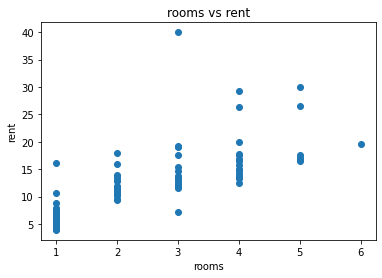

Correlation: 0.6929273993425428


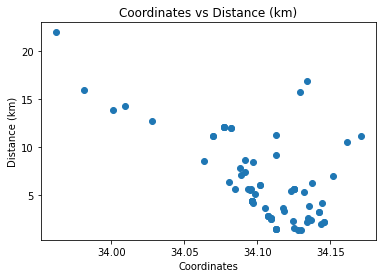

Correlation: -0.6143451255042779


In [221]:
from scipy.stats import pearsonr
# since there are some rws that have an error in their coordinates, but they are not a majority, we are going to remove these to 
# be able to do a pearson correlation
df_study = df[df.Coordinates != 'Error']

# for encoding strings into numbers
def encoding(col,df):
    df_study = df
    encoding = lambda i:dict(enumerate(set(list(df_study[i]))))
    encoding = {v:k for k,v in encoding(col).items()}
    return [encoding[i] for i in df_study[col]]


encoding_coord = lambda col:[np.mean(i) for i in df_study[col]]

# investigate the correlations the different features have with each other

def feature_correlations(df_study,plot=True):
    checked,columns,correlations = [],list(df_study.columns),{k:[] for k in df_study.columns}

    for i in range(len(df_study.columns)):
        for j in range(len(df_study.columns)):
            if i != j and i != 0:
                if j not in checked:
                    
                    # print(columns[i],'vs',columns[j])                
                    
                    x,y = list(df_study[columns[i]]),list(df_study[columns[j]])
                    if type(x[0]) == str:
                        x = encoding(columns[i],df=df_study)
                    if type(y[0]) == str:
                        y = encoding(columns[j],df=df_study)                    
                    if type(x[0]) == tuple:
                        x = encoding_coord(columns[i])
                    if type(y[0]) == tuple:
                        y = encoding_coord(columns[j])                                        

                    correlation_coefficient, p_value = pearsonr(x, y)
                    
                    # add to dictionary to have the corrleations of the features with each other in a dic
                    correlations[columns[i]].append({columns[j]:correlation_coefficient})
                    
                    if plot:
                        if correlation_coefficient >= 0.5 or correlation_coefficient <= -0.5:
                            plt.scatter(x,y)
                            plt.xlabel(columns[i])
                            plt.ylabel(columns[j])
                            plt.title('{} vs {}'.format(columns[i],columns[j]))
                            plt.show()
                            print('Correlation:',correlation_coefficient)

            checked.append(i)
    return correlations

correlations = feature_correlations(df_study,plot=True)

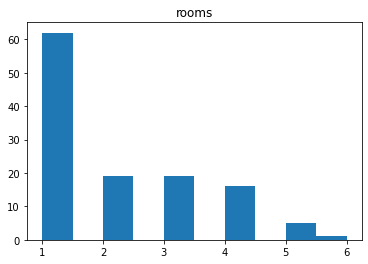

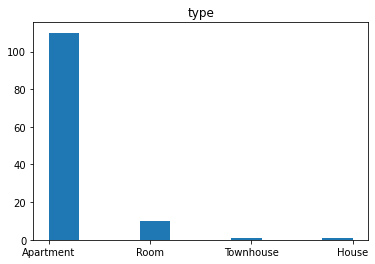

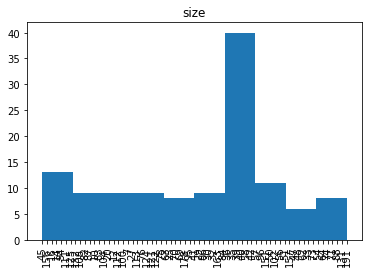

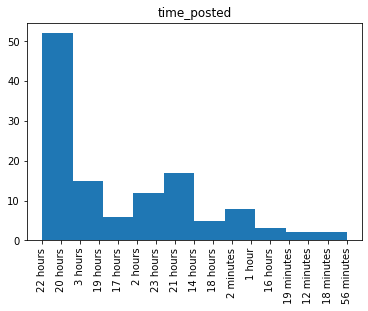

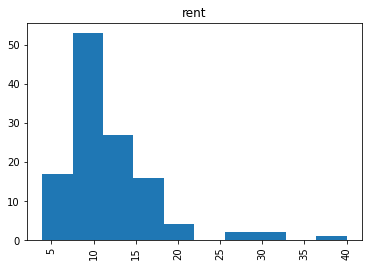

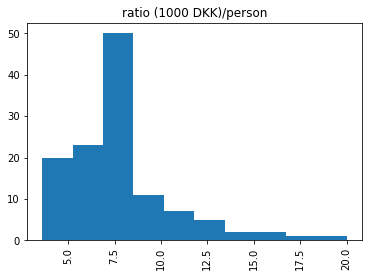

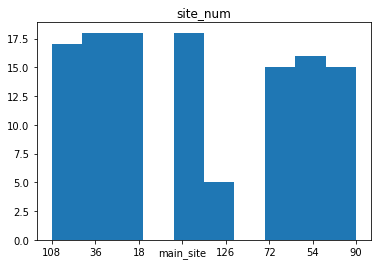

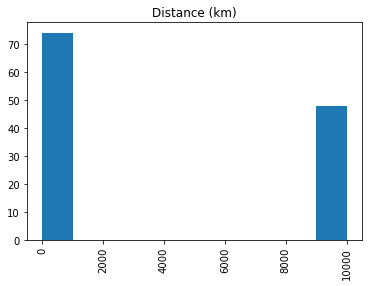

In [262]:
def feature_distributions():
    c = ['rooms','type','size','time_posted','rent','ratio (1000 DKK)/person','site_num','Distance (km)']
    for i in c:    
        try:
            plt.hist(df[i])
            plt.title(i)
            if len(set(list(df[i]))) > 15:
                plt.xticks(rotation=90)        
            plt.show()

        except:
            l = [x for x in df[i] if not isinstance(x,str)]
            plt.hist(l)
            plt.title(i)
            plt.show()        
feature_distributions()            

This can be used to find the webapge of a place. All all the details of the url can be found in the dataset. All I need is the id of the location. This is where I iterate through all possible numbers until i find the right one. To ru all the functions you jsut have to run the last function :)

In [82]:
# make a dictionary with all the required information for the url. All you must do i give the row index as an argument
def url_arguments_dic(df,n=0):
    row = n
    url_dic = {'type':0,'size':0,'n_rooms':0,'id':0}
    if df.iloc[row].type == 'Apartment':
        url_dic['type'] = 'apartments'
    elif df.iloc[row].type == 'Room':
        url_dic['type'] = 'rooms'
    url_dic['size'] = df.iloc[row]['size']
    url_dic['n_rooms'] = int(df.iloc[row]['rooms'])
    url_dic['id'] = int(df.iloc[row]['id'])
    return url_dic


# now out the two functions together in this one to get the info from the page
def apartments_extra_info_extraction(df,n=0):
    d = url_arguments_dic(df=df,n=n)
    print(d)
    url = "https://www.boligportal.dk/en/rental-{}/k%C3%B8benhavn/{}m2-{}-room-id-{}".format(d['type'],d['size'],d['n_rooms'],d['id'])
    print(url)
    response = requests.get(url)

    # Create a BeautifulSoup object and specify the parser
    soup = BeautifulSoup(response.text, "html.parser")    
    sharable = soup.find_all('div',class_='css-h1x6rg')

    info = {}
    for i in sharable:
        try:
            info_type = i.find_all('span',class_='css-arxwps')[0].text
            info_answ = i.find_all('span',class_='css-1h46kg2')[0].text
            info[info_type] = info_answ
        except: pass    
    return info

# to run all the functions above all you have to do is run this one. There is no need to touch anything else
extra_info_dic = apartments_extra_info_extraction(df=df,n=0)
extra_info_dic

{'type': 'apartments', 'size': '150', 'n_rooms': 4, 'id': 5363395}
https://www.boligportal.dk/en/rental-apartments/k%C3%B8benhavn/150m2-4-room-id-5363395


{'Property type': 'Apartment',
 'Size': '150 m²',
 'Rooms': '4',
 'Floor': '1st ',
 'Furnished': 'No',
 'Shareable': 'No',
 'Pets allowed': 'No',
 'Elevator': 'No',
 'Senior friendly': 'No',
 'Students only': 'No',
 'Balcony': 'No',
 'Parking': 'No',
 'Energy rating': '-',
 'Rental period': '1-11 months',
 'Available from': 'As soon as possible',
 'Monthly net rent': '10.455 kr.',
 'Utilities': '1.200 kr.',
 'Deposit': '30.000 kr.',
 'Prepaid rent': '0 kr.',
 'Move-in price': '41.655 kr.',
 'Creation Date': '04/06/2023',
 'Listing-id': '5363395'}